In [ ]:
from IPython.display import clear_output
!pip install pennylane

clear_output()

In [ ]:
import numpy as np
import pandas as pd
import pennylane as qml
import scipy
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import jax
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from PIL import Image
from torchvision.datasets.vision import VisionDataset
import matplotlib.pyplot as plt

In [ ]:
num_qubits = 3
num_layers = 3

In [ ]:
X = np.load('x_data.npy')
y = np.load('y_data.npy')

In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(8000, 16, 16, 3) (2000, 16, 16, 3)
(8000,) (2000,)


In [ ]:
x_train_ = X_train[:,:,:,:]
x_test_ = X_test[:,:,:,:]
y_train_ = Y_train
y_test_ = Y_test

print(x_train_.shape, x_test_.shape)
print(y_train_.shape, y_test_.shape)

(8000, 16, 16, 3) (2000, 16, 16, 3)
(8000,) (2000,)


In [ ]:
# Preprocess the dataset
def preprocess_data(images, labels):
    # images = np.expand_dims(images, -1)
    images = images.astype('float32') / 255.0  # Normalize
    return images, labels

In [ ]:
# x_train_, y_train_ = preprocess_data(x_train_, y_train_)
# x_test_, y_test_ = preprocess_data(x_test_, y_test_)

# print(x_train_.shape, x_test_.shape)
# print(y_train_.shape, y_test_.shape)

In [ ]:
def crop(images, image_size, cropped_size):
    size = image_size
    # x = np.argmax(np.mean(images[:, :, :], axis=0))
    # center = [int(x/size), x%size]
    center = np.unravel_index(np.argmax(images, axis=None), images.shape)
    img_size = cropped_size
    # images = images[:, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]
    if center[0] <= img_size/2 and center[1] > img_size/2:
      images = images[ :(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]
    elif center[0] > img_size/2 and center[1] <= img_size/2:
      images = images[(center[0]-int(img_size/2)):(center[0]+int(img_size/2)), :(center[1]+int(img_size/2))]
    elif center[0] <= img_size/2 and center[1] <= img_size/2:
      images = images[ :(center[0]+int(img_size/2)), :(center[1]+int(img_size/2))]
    else:
      images = images[(center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]
    if images.shape != (img_size, img_size):
      if (img_size - images.shape[0])%2 != 0:
        diff01 = int((img_size - images.shape[0])/2)
        diff11 = int((img_size - images.shape[0])/2) + 1
      else:
        diff01 = int((img_size - images.shape[0])/2)
        diff11 = int((img_size - images.shape[0])/2)
      if (img_size - images.shape[1])%2 != 0:
        diff02 = int((img_size - images.shape[1])/2)
        diff12 = int((img_size - images.shape[1])/2) + 1
      else:
        diff02 = int((img_size - images.shape[1])/2)
        diff12 = int((img_size - images.shape[1])/2)
      # print(center, images.shape)
      images = np.pad(images, ((diff01,diff11),(diff02,diff12)), 'constant', constant_values=(0,0))
      # print(images.shape)
    return images

In [ ]:
# x_train = []
# x_test = []
# y_train = y_train_
# y_test = y_test_
# for i in range(x_train_.shape[0]):
#   x_train.append(crop(x_train_[i], 125, 18))
# for i in range(x_test_.shape[0]):
#   x_test.append(crop(x_test_[i], 125, 18))

# # x_train = np.asarray(x_train, dtype="object")
# # x_test = np.asarray(x_test, dtype="object")
# x_train = np.array(x_train)
# x_test = np.array(x_test)
# print(x_train.shape, x_test.shape)
# print(y_train.shape, y_test.shape)

In [ ]:
x_train = x_train_
x_test = x_test_
y_train = y_train_
y_test = y_test_
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(8000, 16, 16, 3) (2000, 16, 16, 3)
(8000,) (2000,)


In [ ]:
class Electron_Photon_Dataset(VisionDataset):
  def __init__(self, data, labels, train = True, dim=1, root = None, transforms = None, data_transform = None, labels_transform = None):

    super().__init__(root, transforms, transform=data_transform, target_transform=labels_transform)
    self.train = train
    self.data = data
    self.targets = labels
    self.dim = dim

  def __len__(self,):
    return len(self.data)

  def __getitem__(self, index):
    img, label = self.data[index], int(self.targets[index])

    # if self.dim == 1:
    #   img = Image.fromarray(img, mode="L")
    # else:
    #   img = Image.fromarray(np.uint8(img), mode="RGB")

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      label = self.target_transform(label)

    return img, label

In [ ]:
dev = qml.device("default.qubit", wires=num_qubits)


@qml.qnode(dev, interface='torch')
def circuit(inputs, params):
    # Encoding of classical input values using RY gates
    for j in range(num_qubits):
        qml.RY(np.pi * inputs[j], wires=j)

    # Strongly entangled paramterised quantum circuit
    qml.StronglyEntanglingLayers(weights=params, wires=range(num_qubits))     #, imprimitive=qml.ops.CZ

    # Measurement producing 1 classical output value
    return qml.expval(qml.PauliZ(num_qubits-1))

@qml.qnode(dev, interface='torch')
def drc_circuit(inputs, input_params, weights):   #, output_params
    # Encoding of classical input values using RY gates
    drc_layers = input_params.shape[0]

    inputs = torch.reshape(inputs, (drc_layers, int(inputs.shape[0]/drc_layers)))
    for layer in range(drc_layers):
      for j in range(num_qubits):
        # print(f"input_params shape: {input_params.shape}")
        # print(f"inputs shape after reshape: {inputs.shape}")
        # print(f"num_qubits: {num_qubits}")
        qml.RY(input_params[layer,j] * inputs[layer,j], wires=j)  #np.pi

      qml.StronglyEntanglingLayers(weights=weights[layer,:,:].reshape((1,weights.shape[1],weights.shape[2])), wires=range(num_qubits))    #, imprimitive=qml.ops.CZ

    # Measurement producing 1 classical output value
    return qml.expval(qml.PauliZ(num_qubits-1))

head_circuit_qubits = 1
devh = qml.device("default.qubit", wires=head_circuit_qubits)

@qml.qnode(devh, interface='torch')
def head_drc_circuit(inputs, input_params, weights):   #, output_params
    # Encoding of classical input values using RY gates
    drc_layers = input_params.shape[0]

    inputs = torch.reshape(inputs, (drc_layers, int(inputs.shape[0]/drc_layers)))
    for layer in range(drc_layers):
      for j in range(head_circuit_qubits):
        qml.RY(input_params[layer,j] * inputs[layer,j], wires=j)  #np.pi

      # Strongly Entangling paramterised quantum circuit
      qml.StronglyEntanglingLayers(weights=weights[layer,:,:].reshape((1,weights.shape[1],weights.shape[2])), wires=range(head_circuit_qubits))

    return qml.state()
    # return [qml.expval(qml.PauliZ(i)) for i in range(head_circuit_qubits)]

In [ ]:
class QuantumConvolution(torch.nn.Module):
    def __init__(self, input_size, in_filters, out_filters, kernel_size, stride, kernel, layers_per_circuit):
        super(QuantumConvolution, self).__init__()
        self.in_filters = in_filters
        self.out_filters = out_filters
        self.kernel = kernel
        self.kernel_size = kernel_size
        self.stride = stride
        self.lpc = layers_per_circuit
        self.original_input_size = input_size
        self.iter = int(np.ceil(1 + (input_size[0] - self.kernel_size[0])/self.stride))
        drc_layers = int((kernel_size[0]*kernel_size[1]) / num_qubits)
        self.params_per_kernel_shape = qml.StronglyEntanglingLayers.shape(n_layers=drc_layers, n_wires=num_qubits)

        self.upsample = torch.nn.Upsample(size=input_size, mode='bilinear', align_corners=False)

        for o_f in range(self.out_filters):
            for i_f in range(self.in_filters):
                self.add_module('torch_window_'+str(o_f)+str(i_f), qml.qnn.TorchLayer(drc_circuit, {'input_params': (drc_layers, num_qubits), 'weights':self.params_per_kernel_shape}, init_method = torch.nn.init.normal_))

    def forward(self, inputs):
        device = inputs.device

        # Move upsample layer to the same device as inputs
        self.upsample = self.upsample.to(device)

        # Check if input needs to be upsampled
        if inputs.shape[2:] != self.original_input_size:
            inputs = self.upsample(inputs)

        output = torch.zeros((inputs.shape[0], self.out_filters, self.iter, self.iter), device=device)

        for o_f in range(self.out_filters):
            for i_f in range(self.in_filters):
                for l in range(self.iter):
                    for b in range(self.iter):
                        flattened_inputs_window = torch.nn.Flatten()(inputs[:, i_f, l*self.stride : l*self.stride + self.kernel_size[0], b*self.stride : b*self.stride + self.kernel_size[0]])
                        # Move the quantum layer to the same device as inputs
                        quantum_layer = self.get_submodule('torch_window_'+str(o_f)+str(i_f)).to(device)
                        out_i_f = torch.vmap(quantum_layer)(flattened_inputs_window)
                        output[:,o_f,l,b] += out_i_f

        return output

# Usage remains the same:
# qconv = QuantumConvolution(input_size=(125, 125), in_filters, out_filters, kernel_size, stride, kernel, layers_per_circuit)
# output = qconv(inputs)  # inputs can be 16x16 or 125x125, on CPU or GPU

In [ ]:
class QuantumHead(torch.nn.Module):
  def __init__(self, input_size, n_qubits):
    super(QuantumHead, self).__init__()
    self.input_size = input_size
    self.n_qubits = n_qubits
    self.drc_layers = int(self.input_size / self.n_qubits)
    self.params_size = qml.StronglyEntanglingLayers.shape(n_layers=self.drc_layers, n_wires=self.n_qubits)
    self.add_module('quantum_head', qml.qnn.TorchLayer(head_drc_circuit, {'input_params': (self.drc_layers, self.n_qubits), 'weights':self.params_size}, init_method = torch.nn.init.normal_))

  def forward(self, x):
    out = torch.vmap(self.get_submodule('quantum_head'))(x.type(torch.complex64))
    return out  #.type(torch.float32)

In [ ]:
class QuantumModel(torch.nn.Module):
  def __init__(self):
    super(QuantumModel, self).__init__()

    # self.layer_1 = QuantumConvolution(input_size=(28,28), filters=3, kernel_size=(2,2), stride=2, kernel=circuit, layers_per_circuit=1)
    # self.layer_2 = QuantumConvolution(input_size=(14,14), filters=3, kernel_size=(2,2), stride=2, kernel=circuit, layers_per_circuit=num_layers)
    self.layer_3 = QuantumConvolution(input_size=(18+1,18+1), in_filters=1, out_filters=3, kernel_size=(3,3), stride=2, kernel=circuit, layers_per_circuit=num_layers)
    self.layer_4 = QuantumConvolution(input_size=(9,9), in_filters=3, out_filters=1, kernel_size=(3,3), stride=2, kernel=circuit, layers_per_circuit=num_layers)
    # self.layer_5 = QuantumConvolution(input_size=(4+1,4+1), in_filters=2, out_filters=1, kernel_size=(3,3), stride=2, kernel=circuit, layers_per_circuit=1)
    # self.layer_6 = QuantumConvolution(input_size=(2,2), filters=3, kernel_size=(2,2), stride=1, kernel=circuit, layers_per_circuit=1)
    self.layer_7 = torch.nn.Flatten()
    self.layer_8 = QuantumHead(input_size=16, n_qubits=head_circuit_qubits)

  def forward(self, x):
    x = torch.nn.functional.pad(x, (0,1,0,1), 'constant', value = 0)
    x = self.layer_3(x)
    x = self.layer_4(x)
    x = self.layer_7(x)
    x = self.layer_8(x)
    x = torch.nn.functional.normalize(x)

    return x

In [ ]:
qm = QuantumModel()
def count_parameters(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params

count_parameters(qm)

280

In [ ]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

In [ ]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def calculate_fidelity(self, feature_1, feature_2):
      swap_test = SwapTest(feature_1, feature_2)
      fidelity = torch.sub(torch.mul(swap_test[:,0].reshape(feature_1.shape[0], feature_2.shape[0]), 2), 1)
      return fidelity

    def matrix_mul(self, mat1, mat2):
      return torch.matmul(mat1, mat2.T)

    def dot_prod(self, v1, v2):
      return torch.dot(v1,v2)

    def forward(self, features, labels=None, mask=None):

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32) #.to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float() #.to(device)
        else:
            mask = mask.float()

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))


        anchor_dot_contrast = torch.div(
            (torch.vmap(torch.vmap(quantum_state_fidelity, in_dims=(None,0)), in_dims=(0,None)))(anchor_feature, contrast_feature),
            self.temperature
            )
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)

        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1), #.to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [ ]:
from collections import defaultdict

class MetricMonitor:
    def __init__(self, float_precision=4):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
def quantum_state_fidelity(state1, state2):
  return 1 - torch.abs(torch.dot(torch.conj(state1), state2))**2

In [ ]:
def lalign(x, y, alpha=2):
    device = x.device
    dist = torch.vmap(quantum_state_fidelity)(x, y).clip(0)
    return dist.pow(alpha).mean()

def lunif(x, t=2):
    device = x.device
    pdist = torch.vmap(torch.vmap(quantum_state_fidelity, in_dims=(None,0)), in_dims=(0,None))(x,x)
    sq_pdist = torch.tensor([], device=device)

    for i in range(x.shape[0]):
        sq_pdist = torch.cat((sq_pdist, pdist[i][:i]))

    sq_pdist = sq_pdist.flatten().clip(0)
    out = -1 * sq_pdist.mean()

    return out

In [ ]:
def pretraining(epoch, model, contrastive_loader, optimizer, criterion, method='SimCLR', lama=None, lamu=None, alpha=None, t=None):  #SupCon
    "Contrastive pre-training over an epoch"
    metric_monitor = MetricMonitor()
    for batch_idx, (data,labels) in enumerate(contrastive_loader):
        data = torch.cat([data[0], data[1]], dim=0)
        if torch.cuda.is_available():
            data,labels = data.cuda(), labels.cuda()
        data, labels = torch.autograd.Variable(data,False), torch.autograd.Variable(labels)
        bsz = labels.shape[0]
        features = model(data)
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        if method == 'SupCon':
            loss = criterion(features, labels)
        elif method == 'SimCLR':
            loss = criterion(features)
            la = lalign(features[:,0,:], features[:,1,:])
            lux = lunif(features[:,0,:])
            luy = lunif(features[:,1,:])
            print('lalign', la)
            print('luniform', (lux + luy) / 2)
        elif method == 'AlignAndUniform':
            # print(features[:,0,:].shape)
            la = lalign(features[:,0,:], features[:,1,:], alpha)
            lux = lunif(features[:,0,:], t)
            luy = lunif(features[:,1,:], t)
            print('lalign', la)
            print('luniform', (lux + luy) / 2)
            loss = lama * la + lamu * (lux + luy) / 2
        else:
            raise ValueError('contrastive method not supported: {}'.format(method))
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Learning Rate", optimizer.param_groups[0]['lr'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("[Epoch: {epoch:03d}] Contrastive Pre-train | {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Learning Rate']['avg']

In [ ]:
class Z2_Normalization(torch.nn.Module):
  def __init__(self):
    super(Z2_Normalization, self).__init__()

  def forward(self, img):
    if len(img.shape) > 2:
      mean = torch.Tensor([img[0].mean(), img[1].mean(), img[2].mean()])
      std = torch.Tensor([img[0].std(), img[1].std(), img[2].std()])
      return torchvision.transforms.functional.normalize(img, mean, std, inplace=True)
    else:
      return torchvision.transforms.functional.normalize(img, img.mean(), img.std(), inplace=True)

In [ ]:
# def main():

num_epochs = 20
batch_size = 256  #1280
use_early_stopping = True
use_scheduler = False


contrastive_transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomVerticalFlip(p=0.5),
                                    # transforms.RandomRotation([0,180]),
                                    transforms.ToImage(),
                                    transforms.ToDtype(torch.float32, scale=True),
                                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                    # Z2_Normalization(),
                                    ])


contrastive_set = Electron_Photon_Dataset(train=True, dim=3, data = x_train[:5000], labels = y_train[:5000], data_transform=TwoCropTransform(contrastive_transform))

inds = []
for index,i in enumerate(contrastive_set.targets):
  if i == 0 or i == 1:
    inds.append(index)

contrastive_set.data = contrastive_set.data[inds]
contrastive_set.targets = contrastive_set.targets[inds]

# Resizing images to size 8x8
contrastive_set.data = transforms.Resize(18)(contrastive_set.data)
print(contrastive_set.data.shape)
# Define the desired subset size
subset_size = 1024 #5120

# Create a subset of the dataset
subset_indices = torch.randperm(len(contrastive_set), generator=torch.manual_seed(0))[:subset_size]
subset_con = torch.utils.data.Subset(contrastive_set, subset_indices)

contrastive_loader = torch.utils.data.DataLoader(subset_con, batch_size=batch_size, shuffle=True)

(5000, 16, 16, 3)


lalign tensor(6.1062e-15, device='cuda:0', grad_fn=<MeanBackward0>)
luniform tensor(-0.0466, device='cuda:0', grad_fn=<DivBackward0>)
lalign tensor(8.6597e-15, device='cuda:0', grad_fn=<MeanBackward0>)
luniform tensor(-0.0453, device='cuda:0', grad_fn=<DivBackward0>)
lalign tensor(7.4940e-15, device='cuda:0', grad_fn=<MeanBackward0>)
luniform tensor(-0.0526, device='cuda:0', grad_fn=<DivBackward0>)
lalign tensor(7.3830e-15, device='cuda:0', grad_fn=<MeanBackward0>)
luniform tensor(-0.0531, device='cuda:0', grad_fn=<DivBackward0>)
[Epoch: 001] Contrastive Pre-train | Loss: -0.0445 | Learning Rate: 0.0010
lalign tensor(5.9952e-15, device='cuda:0', grad_fn=<MeanBackward0>)
luniform tensor(-0.0509, device='cuda:0', grad_fn=<DivBackward0>)
lalign tensor(5.2736e-15, device='cuda:0', grad_fn=<MeanBackward0>)
luniform tensor(-0.0565, device='cuda:0', grad_fn=<DivBackward0>)
lalign tensor(6.7168e-15, device='cuda:0', grad_fn=<MeanBackward0>)
luniform tensor(-0.0585, device='cuda:0', grad_fn=<Di

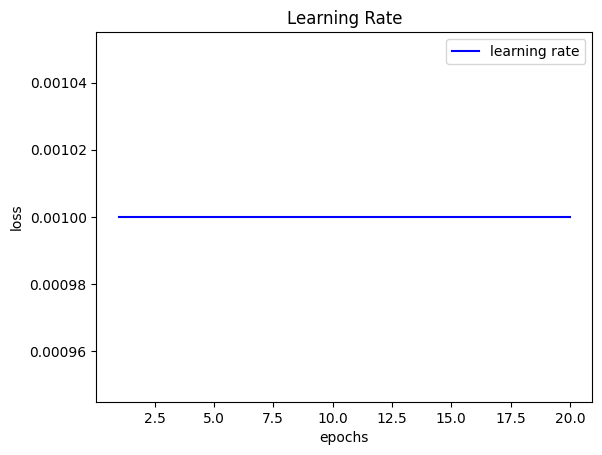

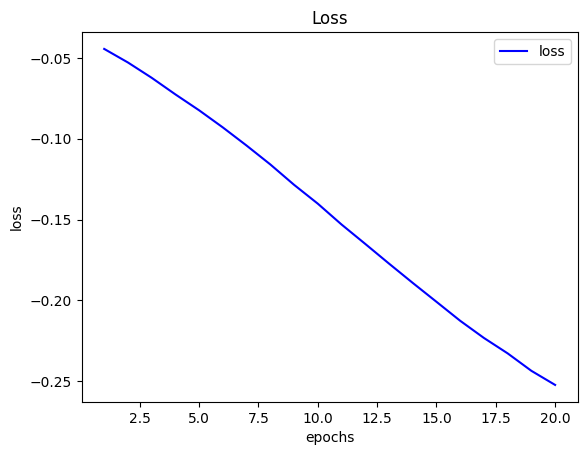

(<matplotlib.legend.Legend at 0x7caf417d9f00>,
 Text(24.0, 0.5, 'loss'),
 Text(0.5, 24.0, 'epochs'),
 Text(0.5, 1.0, 'Loss'),
 None)

In [ ]:
# Part 1
model = QuantumModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)  #, weight_decay=1e-3
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs/5, gamma=0.9)

contrastive_loss, contrastive_lr = [], []


for epoch in range(1, num_epochs+1):
  loss, lr = pretraining(epoch, model, contrastive_loader, optimizer, criterion=None, method='AlignAndUniform', lama=1, lamu=0.9, alpha=2, t=2)  #SupCon #SimCLR #
  if use_scheduler:
    scheduler.step()
  # print(criterion.temperature)
  contrastive_loss.append(loss)
  contrastive_lr.append(lr)

# save_model(model, optimizer, num_epochs, save_file)

plt.plot(range(1,len(contrastive_lr)+1),contrastive_lr, color='b', label = 'learning rate')
plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Learning Rate'), plt.show()

plt.plot(range(1,len(contrastive_loss)+1),contrastive_loss, color='b', label = 'loss')
plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Loss'), plt.show()

In [ ]:
model.training = False
cls_epochs = 1000

cls_data_set = Electron_Photon_Dataset(train=True, dim=3, data = x_train[:5000], labels = y_train[:5000],
                              data_transform=transforms.Compose([ #transforms.ToTensor(),
                                                             transforms.ToImage(),
                                                             transforms.ToDtype(torch.float32, scale=True),
                                                             transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                                            #  Z2_Normalization(),
                                                             ]))

cls_data_set.data = transforms.Resize(18)(cls_data_set.data)
cls_data_set.data = cls_data_set.data[inds]
cls_data_set.targets = cls_data_set.targets[inds]
cls_data_set.data = cls_data_set.data[subset_indices]         #[:1000]
cls_data_set.targets = cls_data_set.targets[subset_indices]    #[:1000]

targets = []
for i in cls_data_set.targets:
  if i == 0:
    targets.append(0)
  else:
    targets.append(1)

a = []
for i, (data, label) in enumerate(cls_data_set):
  a.append(data)

test_set_size = 250

cls_test_set = Electron_Photon_Dataset(train=False, dim=3, data = x_test, labels = y_test,
                              data_transform=transforms.Compose([ #transforms.ToTensor(),
                                                             transforms.ToImage(),
                                                             transforms.ToDtype(torch.float32, scale=True),
                                                             transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                                            #  Z2_Normalization(),
                                                             ]))
testinds = []
for index,i in enumerate(cls_test_set.targets):
  if i == 0 or i == 1:
    testinds.append(index)

cls_test_set.data = transforms.Resize(18)(cls_test_set.data)
cls_test_set.data = cls_test_set.data[testinds]
cls_test_set.targets = cls_test_set.targets[testinds]
cls_test_set.data = cls_test_set.data[:test_set_size]
cls_test_set.targets = cls_test_set.targets[:test_set_size]

testtargets = []
for i in cls_test_set.targets:
  if i == 0:
    testtargets.append(0)
  else:
    testtargets.append(1)

b = []
for i, (data, label) in enumerate(cls_test_set):
  b.append(data)

cls_qubits = int(np.log2(2))
cls_layers = 4

dev3 = qml.device("default.qubit", wires=cls_qubits)

@qml.qnode(dev3, interface='torch', diff_method="backprop")
def classifier_circuit(inputs, params):
  qml.AmplitudeEmbedding(inputs, wires=range(cls_qubits), normalize=True)
  # qml.AngleEmbedding(inputs, wires=range(len(inputs)))
  qml.StronglyEntanglingLayers(weights=params, wires=range(cls_qubits))
  return qml.expval(qml.PauliZ(cls_qubits-1))


quantumclassifier = qml.qnn.TorchLayer(classifier_circuit, {'params': qml.StronglyEntanglingLayers.shape(n_layers=cls_layers, n_wires=cls_qubits)}, init_method = torch.nn.init.normal_)

# random_model = QuantumModel()
# cls_train_data = random_model(torch.stack(a))
cls_train_data = model(torch.autograd.Variable(torch.stack(a), False))   #torch.squeeze(torch.stack(a), 1)
print(cls_train_data.shape)

cls_test_data = model(torch.autograd.Variable(torch.stack(b), False))   #torch.squeeze(torch.stack(a), 1)
print(cls_test_data.shape)

targets = torch.unsqueeze(torch.Tensor(targets), 1)
cls_train_data, targets = torch.autograd.Variable(cls_train_data,False), torch.autograd.Variable(torch.Tensor(targets)).to(torch.float32)

testtargets = torch.unsqueeze(torch.Tensor(testtargets), 1)
cls_test_data, testtargets = torch.autograd.Variable(cls_test_data,False), torch.autograd.Variable(torch.Tensor(testtargets)).to(torch.float32)


import torch
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
import csv

def train_classifier(cls_epochs, classifier, cls_train_data, labels, subset_size, batch_size, cls_test_data, testlabels):
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    cls_loss = []
    cls_accuracy = []
    test_cls_loss = []
    test_cls_accuracy = []
    test_auc = []
    test_f1 = []

    # Prepare CSV output
    csv_filename = 'classifier_metrics.csv'
    csv_header = ['Epoch', 'Test Accuracy', 'AUC', 'F1 Score']

    with open(csv_filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(csv_header)

        for ce in range(cls_epochs):
            correct = 0
            total = 0
            t_correct = 0
            t_total = 0

            optimizer.zero_grad()
            outputs = ((classifier(cls_train_data).type(torch.float32)+1)/2).unsqueeze(1)
            loss = torch.nn.BCELoss()(outputs,labels)
            loss.backward()
            optimizer.step()
            predicted = np.round(outputs.detach().numpy())
            total += labels.size(0)
            correct += np.sum(torch.eq(torch.Tensor(predicted), labels).detach().numpy())
            accuracy = 100 * correct / total
            cls_loss.append(loss.detach().numpy())
            cls_accuracy.append(accuracy)

            # Test data evaluation
            testoutputs = ((classifier(cls_test_data).type(torch.float32)+1)/2).unsqueeze(1)
            testloss = torch.nn.BCELoss()(testoutputs, testlabels)
            testpredicted = np.round(testoutputs.detach().numpy())
            t_total += testlabels.size(0)
            t_correct += np.sum(torch.eq(torch.Tensor(testpredicted), testlabels).detach().numpy())
            testaccuracy = 100 * t_correct / t_total
            test_cls_loss.append(testloss.detach().numpy())
            test_cls_accuracy.append(testaccuracy)

            # Calculate AUC
            auc = roc_auc_score(testlabels.numpy(), testoutputs.detach().numpy())
            test_auc.append(auc)

            # Calculate F1 Score
            f1 = f1_score(testlabels.numpy(), testpredicted.flatten())
            test_f1.append(f1)

            print(f'Epoch: {ce}; Loss: {loss.detach().numpy()}; Accuracy: {accuracy}; Test Loss: {testloss}; Test Accuracy: {testaccuracy}; AUC: {auc}; F1 Score: {f1}')

            # Write to CSV
            csv_writer.writerow([ce, testaccuracy, auc, f1])

    return cls_loss, cls_accuracy, test_cls_loss, test_cls_accuracy, test_auc, test_f1

# Usage
cls_loss, cls_accuracy, test_cls_loss, test_cls_accuracy, test_auc, test_f1 = train_classifier(
    cls_epochs, quantumclassifier, cls_train_data, targets, subset_size, batch_size, cls_test_data, testtargets
)

print("Training completed. Metrics saved in classifier_metrics.csv")

torch.Size([1024, 2])
torch.Size([250, 2])
Epoch: 0; Loss: 0.8711347579956055; Accuracy: 52.24609375; Test Loss: 0.9364339709281921; Test Accuracy: 49.2; AUC: 0.5395315734989647; F1 Score: 0.5993690851735016
Epoch: 1; Loss: 0.8695890307426453; Accuracy: 52.34375; Test Loss: 0.9346117973327637; Test Accuracy: 49.2; AUC: 0.5394668737060041; F1 Score: 0.5993690851735016
Epoch: 2; Loss: 0.8680658936500549; Accuracy: 51.953125; Test Loss: 0.9327843189239502; Test Accuracy: 49.2; AUC: 0.5386904761904762; F1 Score: 0.5993690851735016
Epoch: 3; Loss: 0.86656653881073; Accuracy: 52.1484375; Test Loss: 0.9309508800506592; Test Accuracy: 49.6; AUC: 0.5388198757763976; F1 Score: 0.6012658227848101
Epoch: 4; Loss: 0.8650909662246704; Accuracy: 52.24609375; Test Loss: 0.9291130304336548; Test Accuracy: 49.6; AUC: 0.538366977225673; F1 Score: 0.6012658227848101
Epoch: 5; Loss: 0.8636399507522583; Accuracy: 52.1484375; Test Loss: 0.9272711873054504; Test Accuracy: 49.6; AUC: 0.5380434782608695; F1 Sco

<ipython-input-28-53820570f3b4>:119: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:305.)
  outputs = ((classifier(cls_train_data).type(torch.float32)+1)/2).unsqueeze(1)


Epoch: 6; Loss: 0.8622139096260071; Accuracy: 52.05078125; Test Loss: 0.9254267811775208; Test Accuracy: 49.6; AUC: 0.5372670807453416; F1 Score: 0.6012658227848101
Epoch: 7; Loss: 0.8608132600784302; Accuracy: 52.1484375; Test Loss: 0.9235802292823792; Test Accuracy: 50.0; AUC: 0.5372023809523809; F1 Score: 0.6031746031746031
Epoch: 8; Loss: 0.8594386577606201; Accuracy: 51.953125; Test Loss: 0.9217325448989868; Test Accuracy: 50.0; AUC: 0.5371376811594203; F1 Score: 0.6031746031746031
Epoch: 9; Loss: 0.8580901026725769; Accuracy: 51.953125; Test Loss: 0.9198863506317139; Test Accuracy: 50.0; AUC: 0.5367494824016563; F1 Score: 0.6031746031746031
Epoch: 10; Loss: 0.8567687273025513; Accuracy: 51.953125; Test Loss: 0.9180415868759155; Test Accuracy: 50.4; AUC: 0.5365553830227743; F1 Score: 0.6050955414012739
Epoch: 11; Loss: 0.8554741740226746; Accuracy: 52.05078125; Test Loss: 0.9162003397941589; Test Accuracy: 50.4; AUC: 0.535649585921325; F1 Score: 0.6050955414012739
Epoch: 12; Loss:

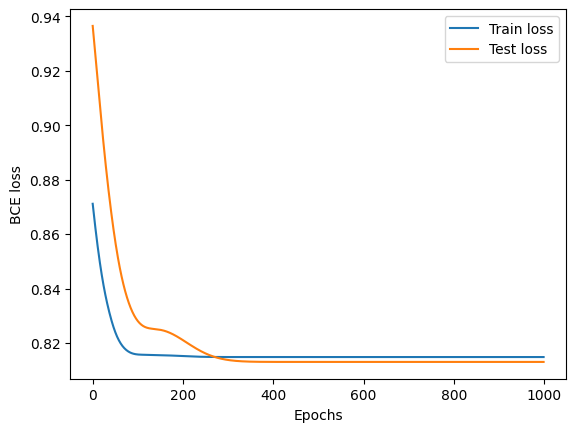

In [ ]:
plt.plot(cls_loss, label='Train loss')
plt.plot(test_cls_loss, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.legend()

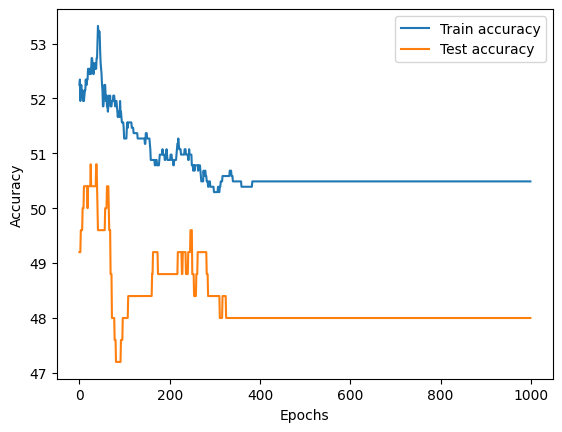

In [ ]:
plt.plot(cls_accuracy, label='Train accuracy')
plt.plot(test_cls_accuracy, label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
from sklearn.neighbors import KernelDensity

v = []
for i, (data, label) in enumerate(cls_data_set):
  v.append(data)

# randommodel = QuantumModel()
# vdata = randommodel(torch.stack(a)).detach().numpy()
vdata = model(torch.autograd.Variable(torch.stack(v), False)).detach().numpy()

In [ ]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(vdata)
gv = kde.score_samples(vdata)

gvs = kde.sample(1024)
plt.scatter(gvs[:,0], gvs[:,1])

ValueError: Complex data not supported
[[-0.35237643+0.76716906j  0.39940932+0.35742813j]
 [-0.0213119 +0.36822122j  0.5316536 +0.7624327j ]
 [-0.4121161 +0.1002431j   0.7806789 -0.4589688j ]
 ...
 [ 0.07808407+0.35197604j  0.5824711 +0.7285214j ]
 [-0.38167268+0.77816844j  0.37498575+0.32888535j]
 [-0.26953718+0.8436253j   0.39159334+0.24960153j]]


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


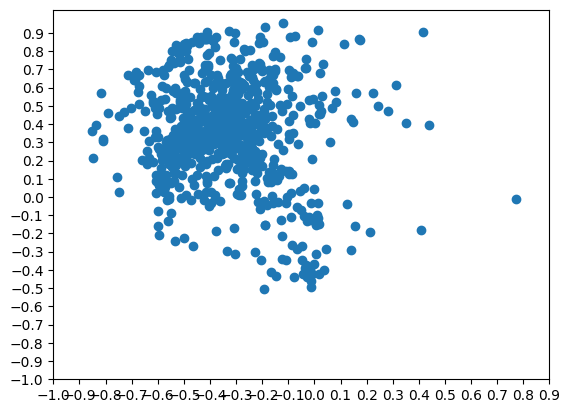

In [ ]:
plt.scatter(vdata[:,0], vdata[:,1])
plt.xticks(np.arange(-1,1,0.1))
plt.yticks(np.arange(-1,1,0.1))
plt.show()

In [ ]:
class_0 = np.array([[0,0]])
class_1 = np.array([[0,0]])
for i,t in enumerate(cls_data_set.targets):
  if t == 1:
    class_1 = np.append(class_1, [vdata[i]],axis=0)
  else:
    class_0 = np.append(class_0, [vdata[i]],axis=0)

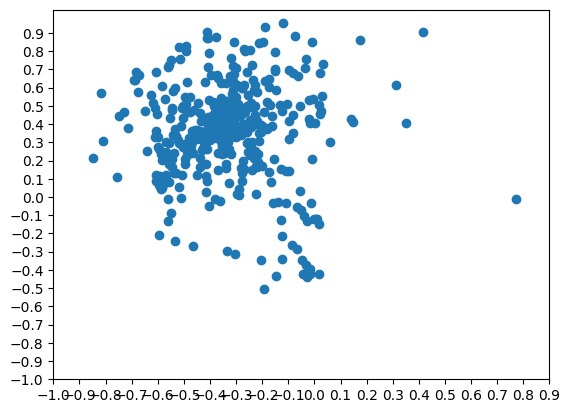

In [ ]:
plt.scatter(class_1[1:,0],class_1[1:,1])
plt.xticks(np.arange(-1,1,0.1))
plt.yticks(np.arange(-1,1,0.1))
plt.show()

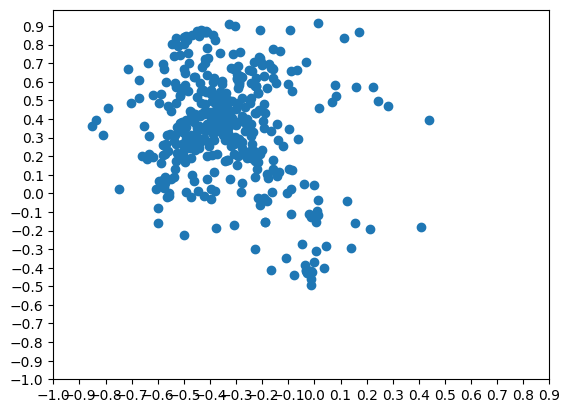

In [ ]:
plt.scatter(class_0[1:,0],class_0[1:,1])
plt.xticks(np.arange(-1,1,0.1))
plt.yticks(np.arange(-1,1,0.1))
plt.show()